# Experimentation: Segmenation
---

In [1]:
# Import libraries
import sys
sys.path.append("..")

from monai.config import print_config
from monai.networks.nets import SwinUNETR
from src.preprocessing import get_transforms, get_datasets, get_dataloaders

import torch
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Set the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# Get transforms
transform = get_transforms()

# Get datasets
train_ds, val_ds = get_datasets(root_dir="../data", collection="HCC-TACE-Seg", transform=transform, download=False, download_len=1, val_frac=0.2)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

train_dl =train_ds.datalist
val_dl = val_ds.datalist


# Check length of datasets and dataloaders
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))

[ 43  68   3  74  82  75   6  86  84  79  63  97  90  71  53  27  18  59
  89  60  93 103   1  76  42  41   4  15  17  40  38   5  95  54   0  34
  28  55  50  11  35  23  52  10  31  78  57  80  91  32  94  14  73  19
  29  49 101 102  69  20  98  72  77  25  37  81  46  39  65  58  12  92
  88  70  87  36  21  83   9 100  67  64  47  44] [26 61  2 62 85 48 16 99 56 45 66 96 51 13  7 30 22 24 33  8]
84 20


In [3]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

print(image.shape, seg.shape)

mip, _ = torch.max(seg, dim=-1)
mip = mip.squeeze()
print(mip.size())


torch.Size([1, 1, 96, 96, 32]) torch.Size([1, 96, 96, 32])
torch.Size([96, 96])


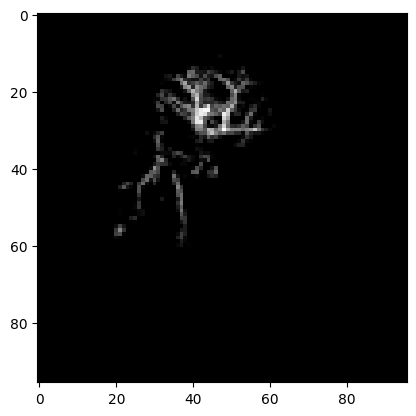

In [4]:
plt.imshow(mip, cmap='gray')

In [5]:
# Create a Swin-UNet model
model = SwinUNETR(img_size=(96, 96, 32), in_channels=1, out_channels=2, use_v2 = True, spatial_dims=3, normalize=True)

c:\Users\Sven\anaconda3\envs\torch\Lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [30]:
wandb.login()


# Set the model to use the GPU
model = model.to(device)

# Set the hyperparameters for training
max_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5
val_interval = 1

run = wandb.init(
    # Set the project where this run will be logged
    project="HCC TACE", name="1.3",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": {learning_rate},
        "epochs": {max_epochs},
        "Weight decay": {weight_decay},
        "Batch_size": {1},
    },
)

# Set the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1e5))

# Create the training loop

# Set the model to training mode
model.train()

# Iterate over the training data for the specified number of epochs
for epoch in range(max_epochs):
    for batch in train_loader:
        # Extract the image and segmentation from the batch
        image, seg = batch["image"].to(device), batch["seg"].to(device).long()

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(image)
        pred = torch.argmax(output, dim=1)
        print(pred.size())
        print(seg.size())
        
        # Compute the loss
        loss = loss_function(pred, seg)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        run.log({"Train loss": loss.item()})
        
    # Print the loss for each epoch
    print(f"Epoch [{epoch+1}/{max_epochs}], Loss: {loss.item():.4f}")
    
    # Set the model to evaluation mode
    model.eval()
    
    # Compute the validation loss
    with torch.no_grad():
        for batch in val_loader:
            image, seg = batch["image"].to(device), batch["seg"].to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1)
            loss = loss_function(pred, seg)
        print(f"Validation Loss: {loss.item():.4f}")
        run.log({"Validation loss": loss.item()})

    

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


torch.Size([1, 96, 96, 32])
torch.Size([1, 96, 96, 32])


RuntimeError: result type Float can't be cast to the desired output type Long

In [17]:
run.finish()


Train loss,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▁
Train loss,6.23611
Validation loss,16.20337


In [9]:
# Save the model
torch.save(model.state_dict(), "../models/arteries-2.pth")

In [ ]:
loss_function = torch.nn.MSELoss()

5.830029010772705


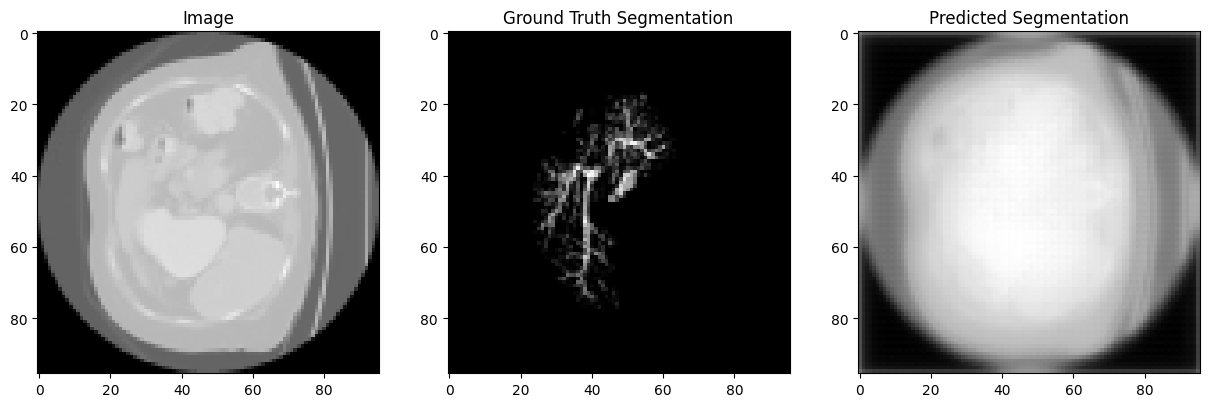

In [19]:

# TODO: Saving a CT volume tensor to image format (DICOM / NIFTI)
#loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10000))


# Load the model
#model.load_state_dict(torch.load("../models/arteries-2.pth"))

# Set the model to evaluation mode
model.eval()

# Sample a batch of data from the test dataloader to make predictions
batch = next(iter(train_loader))

# Extract the image and segmentation from the batch
image, seg = batch["image"].to(device), batch["seg"].to(device).squeeze()

# Make predictions on the image
output = model(image).squeeze()

print(loss_function(output,seg).item())

#MIP
#output,_ =torch.max(output, dim = -1)
seg,_ = torch.max(seg, dim = -1)

# Get the predicted segmentation class for each pixel
pred_seg = output


# Visualize the image, ground truth segmentation, and predicted segmentation
import matplotlib.pyplot as plt
import numpy as np

slice_idx = 16



# Convert the image, ground truth segmentation, and predicted segmentation to NumPy arrays
image = image.cpu().detach().numpy()
seg = seg.cpu().detach().numpy()
pred_seg = pred_seg.cpu().detach().numpy()

# Get the first image, ground truth segmentation, and predicted segmentation from the batch
image = image[0, 0, :, :, slice_idx]
pred_seg = pred_seg[:,:,slice_idx]


# Plot the image, ground truth segmentation, and predicted segmentation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Image")
axes[1].imshow(seg, cmap="gray")
axes[1].set_title("Ground Truth Segmentation")
axes[2].imshow(pred_seg, cmap="gray")
axes[2].set_title("Predicted Segmentation")
plt.show()

